Online Convolutional Dictionary Learning with Spatial Mask
==========================================================

This example demonstrates the use of [dictlrn.onlinecdl.OnlineConvBPDNMaskDictLearn](http://sporco.rtfd.org/en/latest/sporco.dictlrn.onlinecdl.html#sporco.dictlrn.onlinecdl.OnlineConvBPDNMaskDictLearn) for learning a convolutional dictionary from a set of training images. The dictionary is learned using the online dictionary learning algorithm proposed in [[21]](http://sporco.rtfd.org/en/latest/zreferences.html#liu-2018-first).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.dictlrn import onlinecdl
from sporco import util
from sporco import cuda
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.5, gray=True)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S3 = exim.image('monarch.png', idxexp=np.s_[:, 160:672])
S4 = exim.image('sail.png', idxexp=np.s_[:, 210:722])
S5 = exim.image('tulips.png', idxexp=np.s_[:, 30:542])
S = np.dstack((S1, S2, S3, S4, S5))

Highpass filter training images.

In [3]:
npd = 16
fltlmbd = 5
sl, sh = util.tikhonov_filter(S, fltlmbd, npd)

Create random mask and apply to highpass filtered training image set.

In [4]:
frc = 0.25
W = util.rndmask(S.shape, frc, dtype=np.float32)
shw = W * sh

Construct initial dictionary.

In [5]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 32)

Set regularization parameter and options for dictionary learning solver.

In [6]:
lmbda = 0.1
opt = onlinecdl.OnlineConvBPDNMaskDictLearn.Options({
                'Verbose': True, 'ZeroMean': False, 'eta_a': 10.0,
                'eta_b': 20.0, 'DataType': np.float32,
                'CBPDN': {'rho': 3.0, 'AutoRho': {'Enabled': False},
                    'RelaxParam': 1.8, 'RelStopTol': 1e-4, 'MaxMainIter': 100,
                    'FastSolve': False, 'DataType': np.float32}})
if cuda.device_count() > 0:
    opt['CUDA_CBPDN'] = True

Create solver object and solve.

In [7]:
d = onlinecdl.OnlineConvBPDNMaskDictLearn(D0, lmbda, opt)

iter = 50
d.display_start()
for it in range(iter):
    img_index = np.random.randint(0, sh.shape[-1])
    d.solve(shw[..., [img_index]], W[..., [img_index]])

d.display_end()
D1 = d.getdict()
print("OnlineConvBPDNMaskDictLearn solve time: %.2fs" %
      d.timer.elapsed('solve'))

Itn   X r       X s       X ρ       D cnstr   D dlt     D η     
----------------------------------------------------------------


   0  0.00e+00  0.00e+00  0.00e+00  3.78e+01  2.22e+00  5.00e-01


   1  0.00e+00  0.00e+00  0.00e+00  1.50e+01  1.07e+00  4.76e-01


   2  0.00e+00  0.00e+00  0.00e+00  1.37e+01  7.04e-01  4.55e-01


   3  0.00e+00  0.00e+00  0.00e+00  1.30e+01  5.34e-01  4.35e-01


   4  0.00e+00  0.00e+00  0.00e+00  2.91e+01  1.16e+00  4.17e-01


   5  0.00e+00  0.00e+00  0.00e+00  2.77e+01  8.15e-01  4.00e-01


   6  0.00e+00  0.00e+00  0.00e+00  2.65e+01  6.05e-01  3.85e-01


   7  0.00e+00  0.00e+00  0.00e+00  1.09e+01  5.91e-01  3.70e-01


   8  0.00e+00  0.00e+00  0.00e+00  1.05e+01  4.17e-01  3.57e-01


   9  0.00e+00  0.00e+00  0.00e+00  2.29e+01  8.11e-01  3.45e-01


  10  0.00e+00  0.00e+00  0.00e+00  2.21e+01  1.40e+00  3.33e-01


  11  0.00e+00  0.00e+00  0.00e+00  2.03e+01  6.94e-01  3.23e-01


  12  0.00e+00  0.00e+00  0.00e+00  1.97e+01  4.51e-01  3.12e-01


  13  0.00e+00  0.00e+00  0.00e+00  2.11e+01  6.21e-01  3.03e-01


  14  0.00e+00  0.00e+00  0.00e+00  2.04e+01  4.41e-01  2.94e-01


  15  0.00e+00  0.00e+00  0.00e+00  1.77e+01  9.67e-01  2.86e-01


  16  0.00e+00  0.00e+00  0.00e+00  7.87e+00  3.98e-01  2.78e-01


  17  0.00e+00  0.00e+00  0.00e+00  7.75e+00  3.22e-01  2.70e-01


  18  0.00e+00  0.00e+00  0.00e+00  1.57e+01  6.72e-01  2.63e-01


  19  0.00e+00  0.00e+00  0.00e+00  1.52e+01  5.00e-01  2.56e-01


  20  0.00e+00  0.00e+00  0.00e+00  1.48e+01  4.07e-01  2.50e-01


  21  0.00e+00  0.00e+00  0.00e+00  1.44e+01  3.47e-01  2.44e-01


  22  0.00e+00  0.00e+00  0.00e+00  6.97e+00  3.84e-01  2.38e-01


  23  0.00e+00  0.00e+00  0.00e+00  6.89e+00  3.11e-01  2.33e-01


  24  0.00e+00  0.00e+00  0.00e+00  1.61e+01  5.61e-01  2.27e-01


  25  0.00e+00  0.00e+00  0.00e+00  1.58e+01  3.91e-01  2.22e-01


  26  0.00e+00  0.00e+00  0.00e+00  1.41e+01  6.02e-01  2.17e-01


  27  0.00e+00  0.00e+00  0.00e+00  1.29e+01  4.91e-01  2.13e-01


  28  0.00e+00  0.00e+00  0.00e+00  1.25e+01  3.56e-01  2.08e-01


  29  0.00e+00  0.00e+00  0.00e+00  1.33e+01  5.37e-01  2.04e-01


  30  0.00e+00  0.00e+00  0.00e+00  1.43e+01  4.43e-01  2.00e-01


  31  0.00e+00  0.00e+00  0.00e+00  1.22e+01  4.46e-01  1.96e-01


  32  0.00e+00  0.00e+00  0.00e+00  5.54e+00  2.88e-01  1.92e-01


  33  0.00e+00  0.00e+00  0.00e+00  1.16e+01  3.09e-01  1.89e-01


  34  0.00e+00  0.00e+00  0.00e+00  1.18e+01  4.70e-01  1.85e-01


  35  0.00e+00  0.00e+00  0.00e+00  5.31e+00  2.73e-01  1.82e-01


  36  0.00e+00  0.00e+00  0.00e+00  1.26e+01  3.84e-01  1.79e-01


  37  0.00e+00  0.00e+00  0.00e+00  1.24e+01  3.01e-01  1.75e-01


  38  0.00e+00  0.00e+00  0.00e+00  1.06e+01  3.80e-01  1.72e-01


  39  0.00e+00  0.00e+00  0.00e+00  4.92e+00  2.50e-01  1.69e-01


  40  0.00e+00  0.00e+00  0.00e+00  4.89e+00  2.14e-01  1.67e-01


  41  0.00e+00  0.00e+00  0.00e+00  1.03e+01  4.30e-01  1.64e-01


  42  0.00e+00  0.00e+00  0.00e+00  4.78e+00  2.17e-01  1.61e-01


  43  0.00e+00  0.00e+00  0.00e+00  1.01e+01  3.36e-01  1.59e-01


  44  0.00e+00  0.00e+00  0.00e+00  9.49e+00  5.56e-01  1.56e-01


  45  0.00e+00  0.00e+00  0.00e+00  4.58e+00  2.17e-01  1.54e-01


  46  0.00e+00  0.00e+00  0.00e+00  4.53e+00  1.86e-01  1.52e-01


  47  0.00e+00  0.00e+00  0.00e+00  1.06e+01  3.48e-01  1.49e-01


  48  0.00e+00  0.00e+00  0.00e+00  8.94e+00  3.27e-01  1.47e-01


  49  0.00e+00  0.00e+00  0.00e+00  8.83e+00  2.31e-01  1.45e-01
----------------------------------------------------------------
OnlineConvBPDNMaskDictLearn solve time: 16.71s


Display initial and final dictionaries.

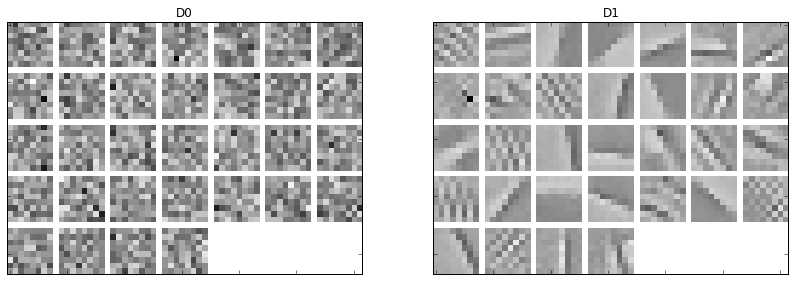

In [8]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0), title='D0', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1), title='D1', fig=fig)
fig.show()

Get iterations statistics from solver object and plot functional value.

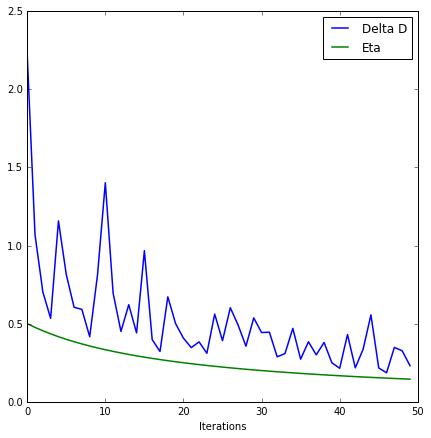

In [9]:
its = d.getitstat()
fig = plot.figure(figsize=(7, 7))
plot.plot(np.vstack((its.DeltaD, its.Eta)).T, xlbl='Iterations',
          lgnd=('Delta D', 'Eta'), fig=fig)
fig.show()